# CAC40 data retrieval

[CAC40 Data retrieval](#data)
- [CAC40 index](#index)
- [CAC40 constituents](#constit)

In [32]:
import pandas as pd
import pickle
import yfinance as yf
import requests

## Data retrieval <a id='data'></a>

### CAC40 index  <a id='index'></a>

#### Yahoo finance Data from 1990-03-01 to today

In [2]:
data_cac40 = yf.download('^FCHI', start="1987-12-31", end="2023-09-08")

[*********************100%%**********************]  1 of 1 completed


In [3]:
data_cac40.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-03-01,1836.0,1838.0,1827.0,1832.0,1832.0,0
1990-03-02,1831.0,1860.0,1831.0,1860.0,1860.0,0
1990-03-05,1866.0,1874.0,1862.0,1874.0,1874.0,0
1990-03-06,1869.0,1875.0,1866.0,1872.0,1872.0,0
1990-03-07,1874.0,1881.0,1874.0,1880.0,1880.0,0


In [4]:
cols_to_drop = [c for c in data_cac40.columns if c != 'Close']
data_cac40 = data_cac40.drop(columns=cols_to_drop).rename(columns={'Close': 'cac40_index'})

#### Insert earlier data from 1987-12-31 to 2017-03-17

In [5]:
# https://www.bnains.org/archives/indices/CAC40.TXT
with open('./cac40_data/CAC40.TXT') as f:
    data_cac40_earlier = f.readlines()

data_cac40_dates = [x.split('\t')[0] for x in data_cac40_earlier[1:]]
data_cac40_closing = [x.split('\t')[-2] for x in data_cac40_earlier[1:]]

df_data_cac40_earlier = pd.DataFrame({'cac40_index': data_cac40_closing},  index=data_cac40_dates)
df_data_cac40_earlier.index = pd.to_datetime(df_data_cac40_earlier.index, dayfirst=True)

In [7]:
df_data_cac40_earlier = df_data_cac40_earlier.map(lambda x:float(x))

In [8]:
df_cac40 = pd.concat([df_data_cac40_earlier.loc[:'1990-02'], data_cac40], axis=0)

In [12]:
df_cac40.to_pickle('./cac40_data/df_cac40.pkl')

In [13]:
df_cac40 = pd.read_pickle('./cac40_data/df_cac40.pkl')

In [15]:
df_cac40.head()

,cac40_index
1987-12-31,1000.00
1988-01-04,984.64
1988-01-05,1021.17
1988-01-06,1028.05
1988-01-07,1024.08


<Axes: >

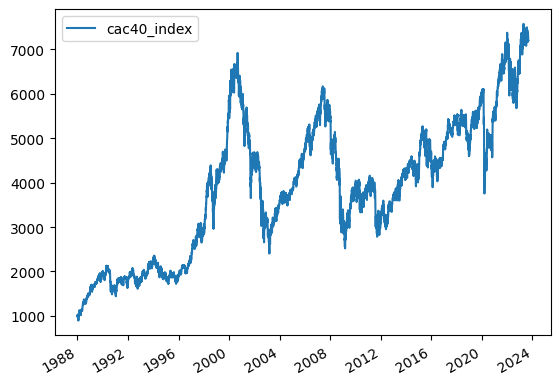

In [14]:
df_cac40.plot()

### CAC40 constituents <a id='constit'></a>

Since CAC40 composition is changing over time, we only retrieve constituents from 20/09/2021 to today (~ 500 trading days).

Note: on 16/06/2023, Vivendi(FR0000127771) was replaced by Edenred(FR0010908533), for the time being this replacement will not be considered in portfolio calculations.

##### retrieving ISIN numbers

In [17]:
# https://www.bnains.org/archives/histocac/compocac.php
with open('./cac40_data/CAC40_20092021.txt') as f:
    isin_numbers = f.readlines()

In [18]:
isin_numbers = [x.strip() for x in isin_numbers]
isin_numbers[:3]

['FR0000120073', 'NL0000235190', 'FR0010220475']

##### converting ISIN numbers to Ticker symbols

In [19]:
#https://quant.stackexchange.com/a/70155
def get_symbol_for_isin(isin):
    url = 'https://query1.finance.yahoo.com/v1/finance/search'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.109 Safari/537.36',
    }
    params = dict(
        q=isin,
        quotesCount=1,
        newsCount=0,
        listsCount=0,
        quotesQueryId='tss_match_phrase_query'
    )
    resp = requests.get(url=url, headers=headers, params=params)
    data = resp.json()
    if 'quotes' in data and len(data['quotes']) > 0:
        return data['quotes'][0]['symbol']
    else:
        return None

In [20]:
isin2ticker = {x:None for x in isin_numbers}

In [24]:
# run this cell several times as some requests are not always completed
for x in isin_numbers:
    if isin2ticker[x] == None:
        isin2ticker[x] = get_symbol_for_isin(x)
        print(x, get_symbol_for_isin(x))

LU0323134006 None
FR0000124711 None


In [25]:
{k:v for (k,v) in isin2ticker.items() if v == None}

{'LU0323134006': None, 'FR0000124711': None}

In [26]:
# manually add missing info
isin2ticker['LU0323134006'] = 'MT'
isin2ticker['FR0000124711'] = 'UNBLF'  

In [28]:
isin2ticker

{'FR0000120073': 'AI.PA',
 'NL0000235190': 'AIR.PA',
 'FR0010220475': 'ALO.PA',
 'LU0323134006': 'MT',
 'FR0000120628': 'CS.PA',
 'FR0000131104': 'BNP.PA',
 'FR0000120503': 'EN.PA',
 'FR0000125338': 'CAP.PA',
 'FR0000120172': 'CA.PA',
 'FR0000045072': 'ACA.PA',
 'FR0000120644': 'BN.PA',
 'FR0000130650': 'DSY.PA',
 'FR0010208488': 'ENGI.PA',
 'FR0000121667': 'EL.PA',
 'FR0014000MR3': 'ERF.PA',
 'FR0000052292': 'RMS.PA',
 'FR0000121485': 'KER.PA',
 'FR0000120321': 'OR.PA',
 'FR0010307819': 'LR.PA',
 'FR0000121014': 'MC.PA',
 'FR0000121261': 'ML.PA',
 'FR0000133308': 'ORA.PA',
 'FR0000120693': 'RI.PA',
 'FR0000130577': 'PUB.PA',
 'FR0000131906': 'RNO.PA',
 'FR0000073272': 'SAF.PA',
 'FR0000125007': 'SGO.PA',
 'FR0000120578': 'SAN.PA',
 'FR0000121972': 'SU.PA',
 'FR0000130809': 'GLE.PA',
 'NL00150001Q9': 'STLAM.MI',
 'NL0000226223': 'STMPA.PA',
 'FR0000051807': 'TEP.PA',
 'FR0000121329': 'HO.PA',
 'FR0000120271': 'TTE.PA',
 'FR0000124711': 'UNBLF',
 'FR0000124141': 'VIE.PA',
 'FR0000125486

In [33]:
with open('./cac40_data/isin2ticker.pkl', 'wb') as f:
    pickle.dump(isin2ticker, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('./cac40_data/isin2ticker.pkl', 'rb') as f:
    isin2ticker = pickle.load(f)

In [34]:
all_tickers = ' '.join([x for x in isin2ticker.values()])

##### stocks histories of prices

In [35]:
dfs = []
for ticker in list(isin2ticker.values()):
    print(ticker)
    data = yf.download(ticker, start="2021-09-20", end="2023-09-08")
    # keep clodsing price only
    cols_to_drop = [c for c in data.columns if c != 'Close']
    dfs.append(data.drop(columns=cols_to_drop).rename(columns={'Close': ticker}))#.isna().value_counts()

AI.PA
[*********************100%%**********************]  1 of 1 completed
AIR.PA
[*********************100%%**********************]  1 of 1 completed
ALO.PA
[*********************100%%**********************]  1 of 1 completed
MT
[*********************100%%**********************]  1 of 1 completed
CS.PA
[*********************100%%**********************]  1 of 1 completed
BNP.PA
[*********************100%%**********************]  1 of 1 completed
EN.PA
[*********************100%%**********************]  1 of 1 completed
CAP.PA
[*********************100%%**********************]  1 of 1 completed
CA.PA
[*********************100%%**********************]  1 of 1 completed
ACA.PA
[*********************100%%**********************]  1 of 1 completed
BN.PA
[*********************100%%**********************]  1 of 1 completed
DSY.PA
[*********************100%%**********************]  1 of 1 completed
ENGI.PA
[*********************100%%**********************]  1 of 1 completed
EL.PA
[*************

In [43]:
df_cac40_stocks = pd.concat(dfs, axis=1)
# Some prices are missing: fill NAs with previous value
df_cac40_stocks.ffill(inplace=True)

In [44]:
df_cac40_stocks.to_pickle('./cac40_data/df_cac40_stocks.pkl')

df_cac40_stocks = pd.read_pickle('./cac40_data/df_cac40_stocks.pkl')

##### stocks returns

In [45]:
df_returns = df_cac40_stocks.pct_change()

In [40]:
df_returns.head(3)

,AI.PA,AIR.PA,ALO.PA,MT,CS.PA,BNP.PA,EN.PA,CAP.PA,CA.PA,ACA.PA,...,STLAM.MI,STMPA.PA,TEP.PA,HO.PA,TTE.PA,UNBLF,VIE.PA,DG.PA,VIV.PA,WLN.PA
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-21,0.021195,0.011971,0.000959,-0.008506,0.011399,0.004106,0.001975,0.024610,0.009215,-0.000892,...,-0.001619,0.013991,0.029605,0.002707,0.006606,0.000000,-0.011418,0.015668,-0.170157,0.00060
2021-09-22,0.000692,0.022599,0.011821,0.021963,0.018564,0.035047,0.015766,-0.002066,0.021644,0.032679,...,0.032435,0.007350,-0.005325,0.009325,0.025594,-0.008505,0.000745,0.011230,0.021429,0.01408


In [41]:
# rapid check for anomalies in returns
pd.DataFrame([df_returns.min(), df_returns.max()]).T

,0,1
AI.PA,-0.043437,0.066656
AIR.PA,-0.114912,0.095719
ALO.PA,-0.104472,0.097492
MT,-0.089103,0.116402
CS.PA,-0.076190,0.078662
BNP.PA,-0.101071,0.099540
EN.PA,-0.064982,0.048789
CAP.PA,-0.070156,0.085823
CA.PA,-0.071624,0.084957
ACA.PA,-0.100570,0.090687
